In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math as m
from scipy.stats import norm
import sys
import seaborn as sns

In [ ]:
transaction_fee = 0.005
mu =0.1
sigma = 0.25
r = 0.05
s_0 = 10
dt = 1 / 252



# Call Option g
K_g = 10
T_g = 1 / 4 # * 365
num_options_g = 10000

# Call Option h
K_h = 10
T_h = 0.3 # * 365
num_days = int(T_g / dt)
num_paths = 5000  # Number of simulations
option_commission_fee = 0.005
stock_commission_fee = 0.005

In [ ]:
def simulate_stock_paths(s_0, mu, sigma, dt, num_days, num_paths, random_seed=None):
    """
    Simulates stock price paths using a geometric Brownian motion model.

    Parameters:
        s0 (float): Initial stock price.
        mu (float): Drift of the stock.
        sigma (float): Volatility of the stock.
        dt (float): Time step size.
        num_days (int): Number of time steps (days).
        num_paths (int): Number of simulated paths.
        random_seed (int, optional): Random seed for reproducibility.

    Returns:
        np.ndarray: Simulated stock price paths of shape (num_paths, num_days + 1).
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Initialize paths
    S_paths = np.zeros((num_paths, num_days + 1))
    S_paths[:, 0] = s_0

    # Simulate paths
    for t in range(1, num_days + 1):
        dW = np.random.normal(0, np.sqrt(dt), num_paths)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW)

    return S_paths
S_paths = simulate_stock_paths(s_0, mu, sigma, dt, num_days, num_paths, random_seed=100)

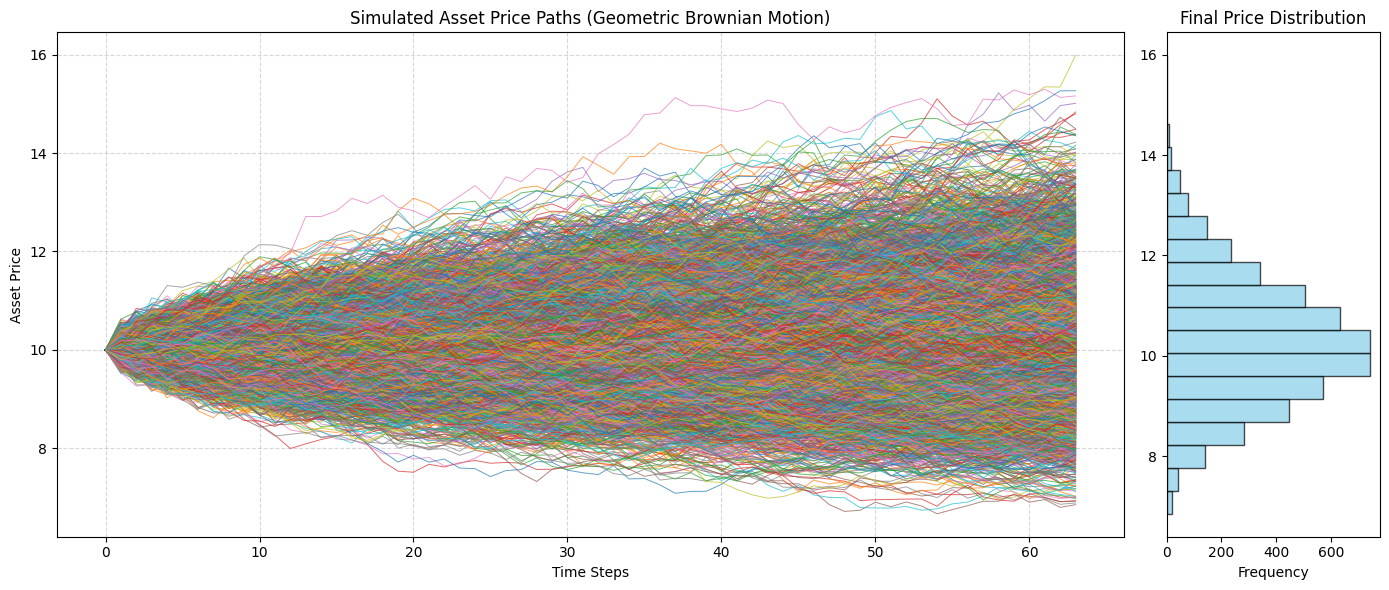

In [ ]:
fig = plt.figure(figsize=(14, 6))
gs = GridSpec(1, 2, width_ratios=[5, 1])

ax0 = plt.subplot(gs[0])
for i in range(num_paths):
    ax0.plot(S_paths[i, :], linewidth=0.7, alpha=0.7)

ax0.set_title('Simulated Asset Price Paths (Geometric Brownian Motion)')
ax0.set_xlabel('Time Steps')
ax0.set_ylabel('Asset Price')
ax0.grid(True, linestyle='--', alpha=0.5)

ax1 = plt.subplot(gs[1])
ax1.hist(S_paths[:, -1], bins=20, orientation='horizontal', color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Frequency')
ax1.set_title('Final Price Distribution')

plt.tight_layout()
plt.show()

In [ ]:
def get_d1(S, K, r, tao, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tao) / (sigma * np.sqrt(tao))

    return d1

def get_delta(S, K, r, tao, sigma):
    d1 = get_d1(S, K, r, tao, sigma)
    delta = norm.cdf(d1)

    return delta

def get_gamma(S, K, r, tao, sigma):
    d1 = get_d1(S, K, r, tao, sigma)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(tao))

    return gamma

def get_call_option_price(S, K, r, tao, sigma):
    d1 = get_d1(S, K, r, tao, sigma)
    s2 = d1 - sigma * np.sqrt(tao)

    n_d1 = norm.cdf(d1)
    n_d2 = norm.cdf(s2)

    call_price = S * n_d1 - K * np.exp(-r * tao) * n_d2

    return call_price


In [ ]:
# Initialize the delta_paths array to store Delta values
num_paths, _ = S_paths.shape
num_steps = int(T_g * 252)
tao_values = T_g - dt * np.arange(num_steps)

delta_paths = np.zeros((num_paths, num_steps))
option_paths = np.zeros((num_paths, num_steps))
gamma_paths = np.zeros((num_paths, num_steps))

# Calculate Delta and Option for all paths
for j in range(num_steps):
    # Compute Delta for all paths at step j
    gamma_paths[:, j] = get_gamma(S_paths[:, j], K_g, r, tao_values[j], sigma)
    delta_paths[:, j] = get_delta(S_paths[:, j], K_g, r, tao_values[j], sigma)
    option_paths[:, j] = get_call_option_price(S_paths[:, j], K_g, r, tao_values[j], sigma)


gamma_option_gamma_paths = np.zeros((num_paths, num_steps))
gamma_option_delta_paths = np.zeros((num_paths, num_steps))
gamma_option_paths = np.zeros((num_paths, num_steps))

tao_values_gamma_option = T_h - dt * np.arange(num_steps)

# Calculate Delta and Option for all paths
for j in range(num_steps):
    # Compute Delta, Gamma for all paths at step j
    gamma_option_gamma_paths[:, j] = get_gamma(S_paths[:, j], K_h, r, tao_values_gamma_option[j], sigma)

    gamma_option_delta_paths[:, j] = get_delta(S_paths[:, j], K_h, r, tao_values_gamma_option[j], sigma)

    gamma_option_paths[:, j] = get_call_option_price(S_paths[:, j], K_h, r, tao_values_gamma_option[j], sigma)

In [ ]:
class PortfolioManager:
    def __init__(self, share_of_stock, share_of_option, cash, share_of_gamma_option=0):
        self.share_of_stock = share_of_stock
        self.share_of_option = share_of_option
        self.share_of_gamma_option = share_of_gamma_option

        self.cash = cash
        self.initial_val = cash

    def get_profit(self, stock_price, k=None, gamma_option_price=0,
                   option_commission_fee=0.005, stock_commission_fee=0.005):
        total_stock_fee = abs(self.share_of_stock) * stock_commission_fee
        total_option_fee = abs(self.share_of_option) * option_commission_fee
        total_gamma_option_fee = abs(self.share_of_gamma_option) * option_commission_fee

        if max(stock_price - k, 0) == 0:
            profit = (self.cash +
                      self.share_of_stock * stock_price +
                      self.share_of_gamma_option * gamma_option_price -
                      total_stock_fee - total_gamma_option_fee -
                      self.initial_val)
        else:
            profit = (self.cash +
                      self.share_of_stock * stock_price +
                      self.share_of_option * max(stock_price - k, 0) +
                      self.share_of_gamma_option * gamma_option_price -
                      total_stock_fee - total_option_fee - total_gamma_option_fee -
                      self.initial_val)

        return profit

    def charge_fee(self, fee):
        self.cash -= fee

    def delta_hedging(self, delta, stock_price, stock_commission_fee):
        total_delta = delta * self.share_of_option

        required_stock_position = int(-total_delta)
        delta_stock_trade = required_stock_position - self.share_of_stock

        self.trade_stock(delta_stock_trade, stock_price, stock_commission_fee)
    def delta_gamma_hedging(self, delta_main, gamma_main, delta_sub, gamma_sub, gamma_option_price, stock_price, stock_commission_fee, option_commission_fee):
        total_gamma_main = gamma_main * self.share_of_option
        if gamma_sub != 0:  # Avoid division by zero
            required_gamma_option_position = int(-total_gamma_main / gamma_sub)
        else:
            required_gamma_option_position = 0
        gamma_option_trade = required_gamma_option_position - self.share_of_gamma_option

        # print(f"Gamma Main: {gamma_main}, Gamma Sub: {gamma_sub}, Required Gamma Option Position: {required_gamma_option_position}")

        self.trade_option(gamma_option_trade, gamma_option_price, option_commission_fee, is_gamma=True)

        total_delta = delta_main * self.share_of_option + delta_sub * self.share_of_gamma_option
        required_stock_position = int(-total_delta)
        delta_stock_trade = required_stock_position - self.share_of_stock

        # print(f"Delta Main: {delta_main}, Delta Sub: {delta_sub}, Required Stock Position: {required_stock_position}")

        self.trade_stock(delta_stock_trade, stock_price, stock_commission_fee)


    def trade_stock(self, trade_position, stock_price, stock_commission_fee):
        # if trade_position != 0:
        #     print(f"Trading Stock: {trade_position}")
        self.share_of_stock += trade_position
        self.cash -= trade_position * stock_price
        self.charge_fee(abs(trade_position) * stock_commission_fee)

    def trade_option(self, trade_position, option_price, option_commission_fee, is_gamma=False):
        # if trade_position != 0:
        #     print(f"Trading Option {'H' if is_gamma else 'G'}: {trade_position}")
        if is_gamma:
            self.share_of_gamma_option += trade_position
        else:
            self.share_of_option += trade_position
        self.cash -= trade_position * option_price
        self.charge_fee(abs(trade_position) * option_commission_fee)


    def update_cash_with_interest(self, r, dt):
        self.cash *= np.exp(r * dt)

    # used to double-check
    def get_total_delta_gamma(self, delta_main, delta_sub, gamma_main, gamma_sub):
        total_delta = self.share_of_stock + (self.share_of_option * delta_main) + (self.share_of_gamma_option * delta_sub)
        total_gamma = (self.share_of_option * gamma_main) + (self.share_of_gamma_option * gamma_sub)

        return total_delta, total_gamma

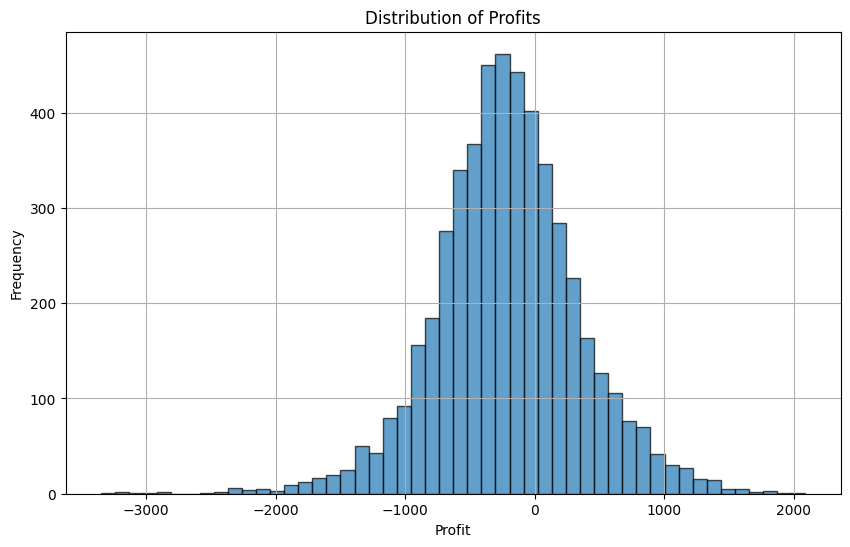

In [ ]:
profits = []

delta_records = []
for path in range(num_paths):
    delta_path = delta_paths[path]
    option_path = option_paths[path]
    stock_path = S_paths[path, :num_steps]

    pm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)

    pm.trade_option(-10000, option_path[0], option_commission_fee)

    gamma_record = []
    delta_record = []
    for i in range(num_steps):
        current_stock_price = stock_path[i]
        current_option_price = option_path[i]
        delta = delta_path[i]

        pm.delta_hedging(delta, current_stock_price, stock_commission_fee)
        pm.update_cash_with_interest(r, dt)

        total_delta, _ = pm.get_total_delta_gamma(delta, 0, 0, 0)
        delta_record.append(total_delta)

    final_profit = pm.get_profit(stock_path[-1], K_g)
    profits.append(final_profit)
    delta_records.append(delta_record)

plt.figure(figsize=(10, 6))
plt.hist(profits, bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of Profits")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.grid(True)

plt.show()

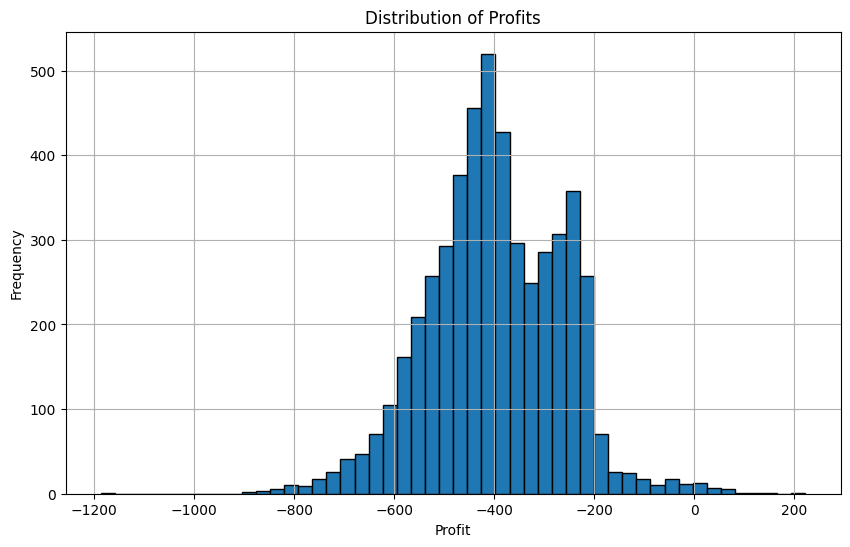

In [ ]:
profits_dgh = []

gamma_records = []
delta_records = []
for path in range(num_paths):
    delta_path = delta_paths[path]
    gamma_path = gamma_paths[path]
    option_path = option_paths[path]
    stock_path = S_paths[path, :num_steps]

    gamma_option_gamma_path = gamma_option_gamma_paths[path]
    gamma_option_delta_path = gamma_option_delta_paths[path]
    gamma_option_price_path = gamma_option_paths[path]

    pm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)

    pm.trade_option(-10000, option_path[0], option_commission_fee)

    gamma_record = []
    delta_record = []
    for i in range(num_steps):
        current_stock_price = stock_path[i]
        current_option_price = option_path[i]
        delta_main = delta_path[i]
        gamma_main = gamma_path[i]

        gamma_option_price = gamma_option_price_path[i]
        delta_sub = gamma_option_delta_path[i]
        gamma_sub = gamma_option_gamma_path[i]

        pm.delta_gamma_hedging(
            gamma_main=gamma_main,
            delta_main=delta_main,
            delta_sub=delta_sub,
            gamma_sub=gamma_sub,
            gamma_option_price=gamma_option_price,
            stock_price=current_stock_price,
            stock_commission_fee=stock_commission_fee,
            option_commission_fee=option_commission_fee
        )
        pm.update_cash_with_interest(r, dt)

        total_delta, total_gamma = pm.get_total_delta_gamma(delta_main, delta_sub, gamma_main, gamma_sub)
        gamma_record.append(total_gamma)
        delta_record.append(total_delta)

    final_profit = pm.get_profit(
        stock_price=stock_path[-1],
        k=K_g,
        gamma_option_price=gamma_option_price_path[-1],
    )

    profits_dgh.append(final_profit)
    gamma_records.append(gamma_record)
    delta_records.append(delta_record)
plt.figure(figsize=(10, 6))
plt.hist(profits_dgh, bins=50, edgecolor='black')
plt.title("Distribution of Profits")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.grid(True)

plt.show()


mu = 0.1 simulation is processing
mu = 0.2 simulation is processing
mu = 0.3 simulation is processing
mu = 0.4 simulation is processing
mu = 0.5 simulation is processing
mu = 0.6 simulation is processing
mu = 0.7 simulation is processing
mu = 0.8 simulation is processing
mu = 0.9 simulation is processing


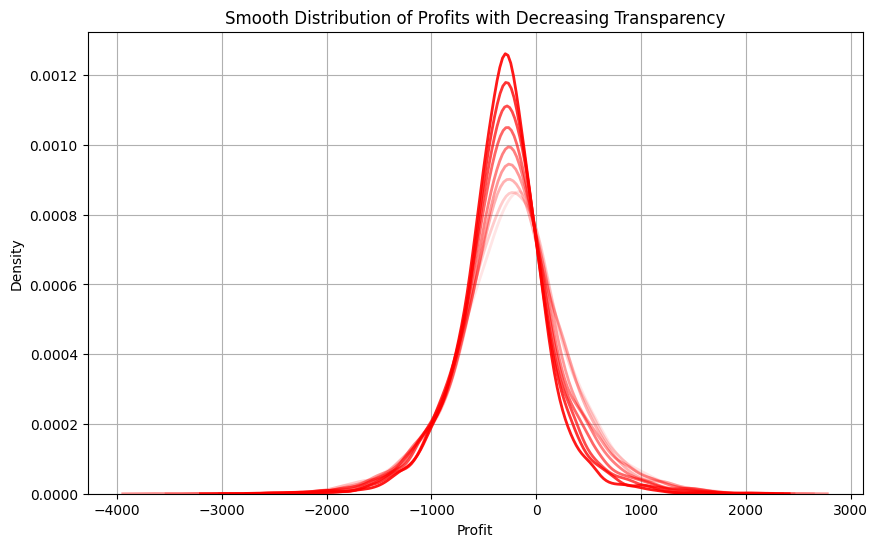

In [ ]:
# Delta Hedging
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

dif_mu_profits_dh = []
dif_mu_delta_records_dh = []

for mu in mus:
    print(f"mu = {mu} simulation is processing")
    # part 1
    # Simulation parameters
    np.random.seed(69)

    num_days = int(T_g / dt)
    num_paths = 5000  # Number of simulations

    # np.random.seed(2)
    S_paths = np.zeros((num_paths, num_days + 1))
    S_paths[:, 0] = s_0

    for t in range(1, num_days + 1):
        dW = np.random.normal(0, np.sqrt(dt), num_paths)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW)


    # part 2
    # Initialize the delta_paths array to store Delta values
    num_paths, _ = S_paths.shape
    num_steps = int(T_g * 252)
    tao_values = T_g - dt * np.arange(num_steps)

    delta_paths = np.zeros((num_paths, num_steps))
    option_paths = np.zeros((num_paths, num_steps))
    gamma_paths = np.zeros((num_paths, num_steps))

    # Calculate Delta and Option for all paths
    for j in range(num_steps):
        # Compute Delta for all paths at step j
        gamma_paths[:, j] = get_gamma(S_paths[:, j], K_g, r, tao_values[j], sigma)
        delta_paths[:, j] = get_delta(S_paths[:, j], K_g, r, tao_values[j], sigma)
        option_paths[:, j] = get_call_option_price(S_paths[:, j], K_g, r, tao_values[j], sigma)


    # part 3
    profits = []
    delta_records = []
    for path in range(num_paths):
        delta_path = delta_paths[path]
        option_path = option_paths[path]
        stock_path = S_paths[path, :num_steps]

        pm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)

        pm.trade_option(-10000, option_path[0], option_commission_fee)


        gamma_record = []
        delta_record = []
        for i in range(num_steps):
            current_stock_price = stock_path[i]
            current_option_price = option_path[i]
            delta = delta_path[i]


            pm.delta_hedging(delta, current_stock_price, stock_commission_fee)
            pm.update_cash_with_interest(r, dt)

            total_delta, _ = pm.get_total_delta_gamma(delta, 0, 0, 0)
            delta_record.append(total_delta)

        final_profit = pm.get_profit(stock_path[-1], K_g)
        profits.append(final_profit)
        delta_records.append(delta_record)

    dif_mu_profits_dh.append(profits)
    dif_mu_delta_records_dh.append(delta_records)
start_alpha = 0.1
alpha_step = 0.1

plt.figure(figsize=(10, 6))
for i, profit in enumerate(dif_mu_profits_dh):
    alpha = max(start_alpha + i * alpha_step, 0.1)
    sns.kdeplot(profit, color='red', linewidth=2, alpha=alpha)

plt.title("Smooth Distribution of Profits with Decreasing Transparency")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.grid(True)

plt.show()



mu = 0.1 simulation is processing
mu = 0.2 simulation is processing
mu = 0.3 simulation is processing
mu = 0.4 simulation is processing
mu = 0.5 simulation is processing
mu = 0.6 simulation is processing
mu = 0.7 simulation is processing
mu = 0.8 simulation is processing
mu = 0.9 simulation is processing


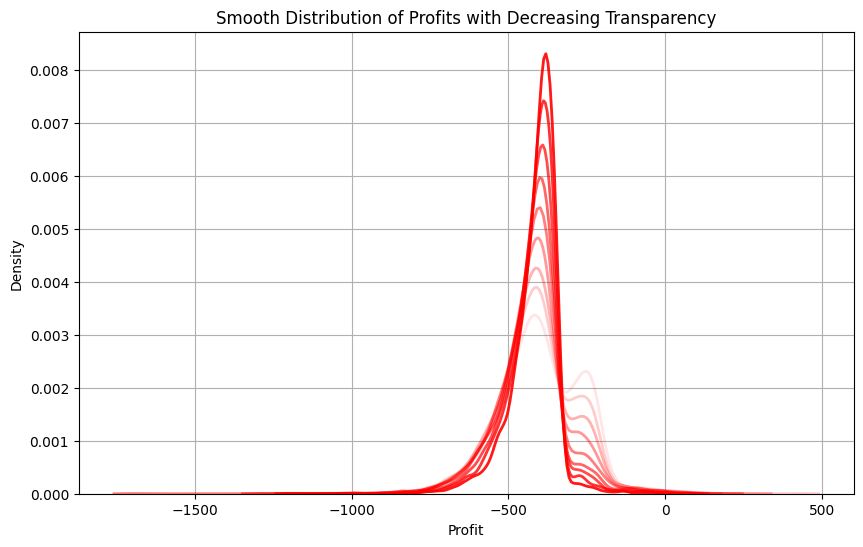

In [ ]:
# Delta Gamma Hedging
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

dif_mu_profits_dgh = []
dif_mu_gamma_records_dgh = []
dif_mu_delta_records_dgh = []

for mu in mus:
    print(f"mu = {mu} simulation is processing")
    # part 1
    # Simulation parameters
    np.random.seed(69)

    num_days = int(T_g / dt)
    num_paths = 5000  # Number of simulations

    # np.random.seed(2)
    S_paths = np.zeros((num_paths, num_days + 1))
    S_paths[:, 0] = s_0

    for t in range(1, num_days + 1):
        dW = np.random.normal(0, np.sqrt(dt), num_paths)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW)

    # part 2
    # Initialize the delta_paths array to store Delta values
    num_paths, _ = S_paths.shape
    num_steps = int(T_g * 252)
    tao_values = T_g - dt * np.arange(num_steps)

    delta_paths = np.zeros((num_paths, num_steps))
    option_paths = np.zeros((num_paths, num_steps))
    gamma_paths = np.zeros((num_paths, num_steps))

    # Calculate Delta and Option for all paths
    for j in range(num_steps):
        # Compute Delta for all paths at step j
        gamma_paths[:, j] = get_gamma(S_paths[:, j], K_g, r, tao_values[j], sigma)
        delta_paths[:, j] = get_delta(S_paths[:, j], K_g, r, tao_values[j], sigma)
        option_paths[:, j] = get_call_option_price(S_paths[:, j], K_g, r, tao_values[j], sigma)

    # part 3
    gamma_option_gamma_paths = np.zeros((num_paths, num_steps))
    gamma_option_delta_paths = np.zeros((num_paths, num_steps))
    gamma_option_paths = np.zeros((num_paths, num_steps))

    tao_values_gamma_option = T_h - dt * np.arange(num_steps)

    # Calculate Delta and Option for all paths
    for j in range(num_steps):
        # Compute Delta, Gamma for all paths at step j
        gamma_option_gamma_paths[:, j] = get_gamma(S_paths[:, j], K_h, r, tao_values_gamma_option[j], sigma)
        gamma_option_delta_paths[:, j] = get_delta(S_paths[:, j], K_h, r, tao_values_gamma_option[j], sigma)
        gamma_option_paths[:, j] = get_call_option_price(S_paths[:, j], K_h, r, tao_values_gamma_option[j], sigma)

    # Part 4
    profits = []

    gamma_records = []
    delta_records = []
    for path in range(num_paths):
        # 获取当前路径的主期权和 Gamma 期权的 delta、gamma、option、stock价格路径
        delta_path = delta_paths[path]  # 主期权的 Delta 路径
        gamma_path = gamma_paths[path]  # 主期权的 Gamma 路径，需要确保你已经计算了 gamma_paths
        option_path = option_paths[path]  # 主期权的价格路径
        stock_path = S_paths[path, :num_steps]  # 股票价格路径

        # Gamma 期权的数据
        gamma_option_gamma_path = gamma_option_gamma_paths[path]
        gamma_option_delta_path = gamma_option_delta_paths[path]
        gamma_option_price_path = gamma_option_paths[path]

        # 初始化 PortfolioManager
        pm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)

        # 初始卖出 10,000 份主期权
        pm.trade_option(-10000, option_path[0], option_commission_fee)

        # 执行 Delta-Gamma 对冲策略
        gamma_record = []
        delta_record = []
        for i in range(num_steps):
            current_stock_price = stock_path[i]
            current_option_price = option_path[i]
            delta_main = delta_path[i]
            gamma_main = gamma_path[i]  # 确保你有 gamma_main 的路径

            gamma_option_price = gamma_option_price_path[i]
            delta_sub = gamma_option_delta_path[i]
            gamma_sub = gamma_option_gamma_path[i]

            pm.delta_gamma_hedging(
                gamma_main=gamma_main,
                delta_main=delta_main,
                delta_sub=delta_sub,
                gamma_sub=gamma_sub,
                gamma_option_price=gamma_option_price,
                stock_price=current_stock_price,
                stock_commission_fee=stock_commission_fee,
                option_commission_fee=option_commission_fee
            )
            pm.update_cash_with_interest(r, dt)

            total_delta, total_gamma = pm.get_total_delta_gamma(delta_main, delta_sub, gamma_main, gamma_sub)
            gamma_record.append(total_gamma)
            delta_record.append(total_delta)

        # 计算最终利润
        # get_profit(self, stock_price, option_price, exercise_option, k=None, is_gamma=False)
        final_profit = pm.get_profit(
            stock_price=stock_path[-1],
            k=K_g,
            gamma_option_price=gamma_option_price_path[-1],
        )

        profits.append(final_profit)
        gamma_records.append(gamma_record)
        delta_records.append(delta_record)

    dif_mu_profits_dgh.append(profits)
    dif_mu_gamma_records_dgh.append(gamma_records)
    dif_mu_delta_records_dgh.append(delta_records)
start_alpha = 0.1
alpha_step = 0.1

plt.figure(figsize=(10, 6))
for i, profit in enumerate(dif_mu_profits_dgh):
    alpha = max(start_alpha + i * alpha_step, 0.1)
    sns.kdeplot(profit, color='red', linewidth=2, alpha=alpha)

plt.title("Smooth Distribution of Profits with Decreasing Transparency")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.grid(True)

plt.show()


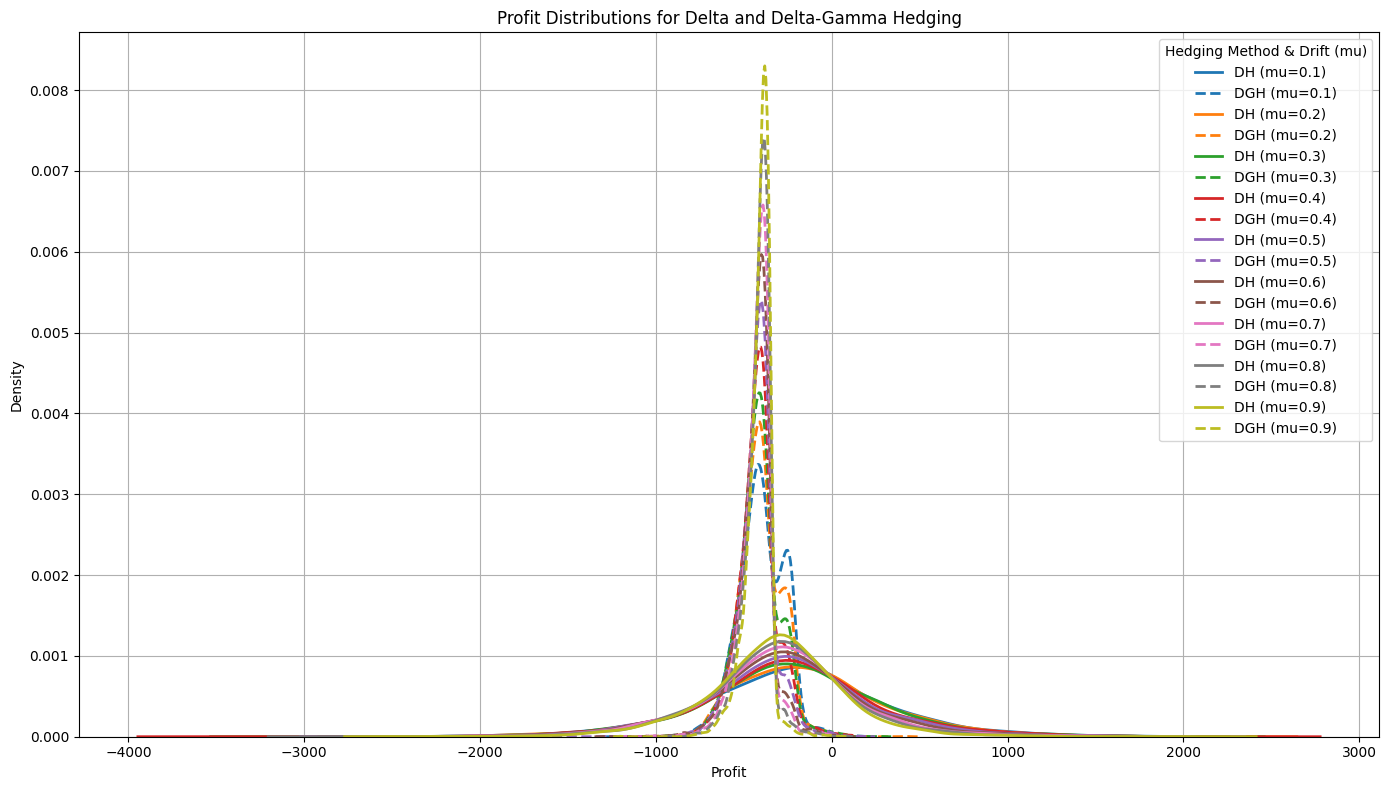

In [ ]:
plt.figure(figsize=(14, 8))

# Start plotting the line chart for DH and DGH
for i, mu in enumerate(mus):
    # Smooth line for Delta Hedging (DH) profits
    sns.kdeplot(
        dif_mu_profits_dh[i],
        label=f"DH (mu={mu})",
        linestyle="-",
        linewidth=2,
        color=f"C{i}",
    )

    # Smooth line for Delta-Gamma Hedging (DGH) profits
    sns.kdeplot(
        dif_mu_profits_dgh[i],
        label=f"DGH (mu={mu})",
        linestyle="--",
        linewidth=2,
        color=f"C{i}",
    )

# Add legend, labels, and title
plt.legend(loc="upper right", title="Hedging Method & Drift (mu)")
plt.title("Profit Distributions for Delta and Delta-Gamma Hedging")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


# Q2

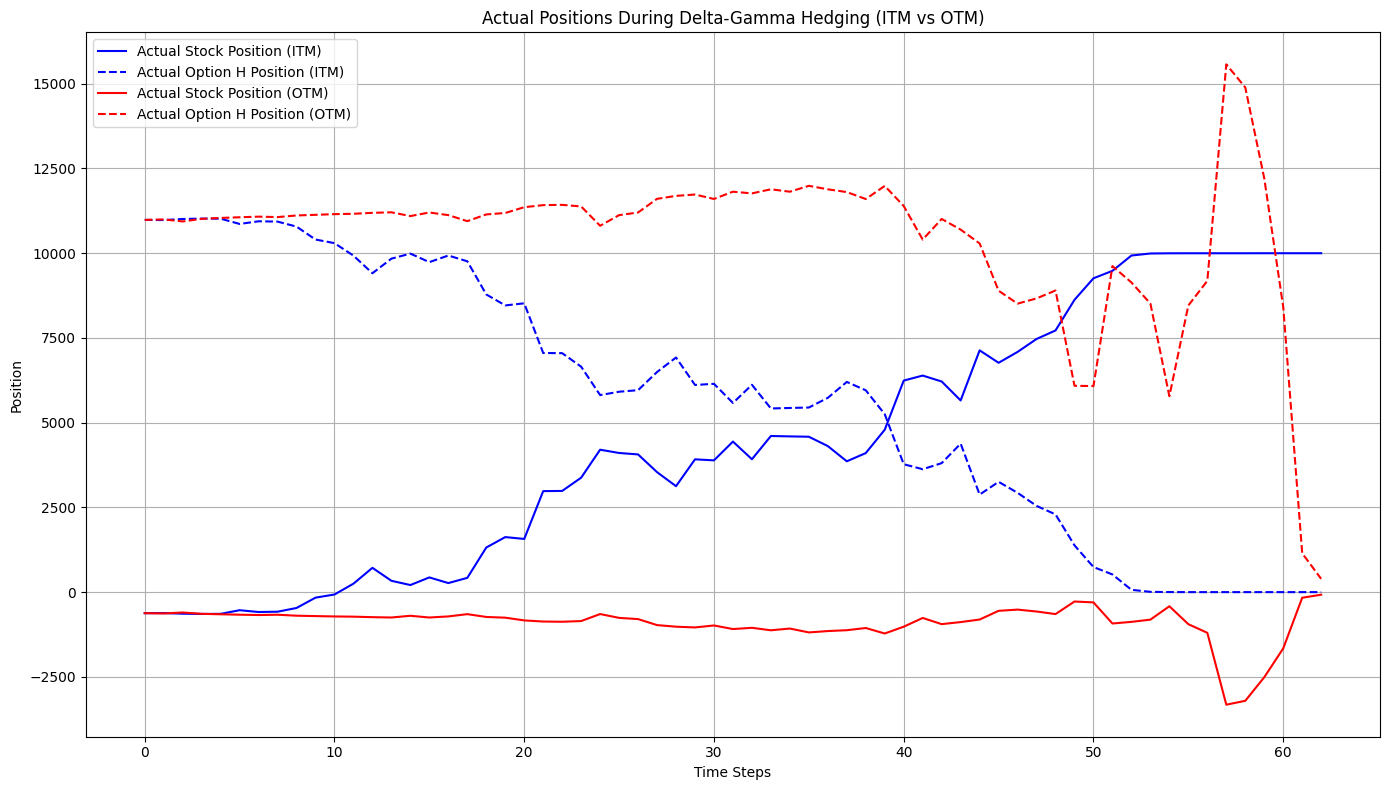

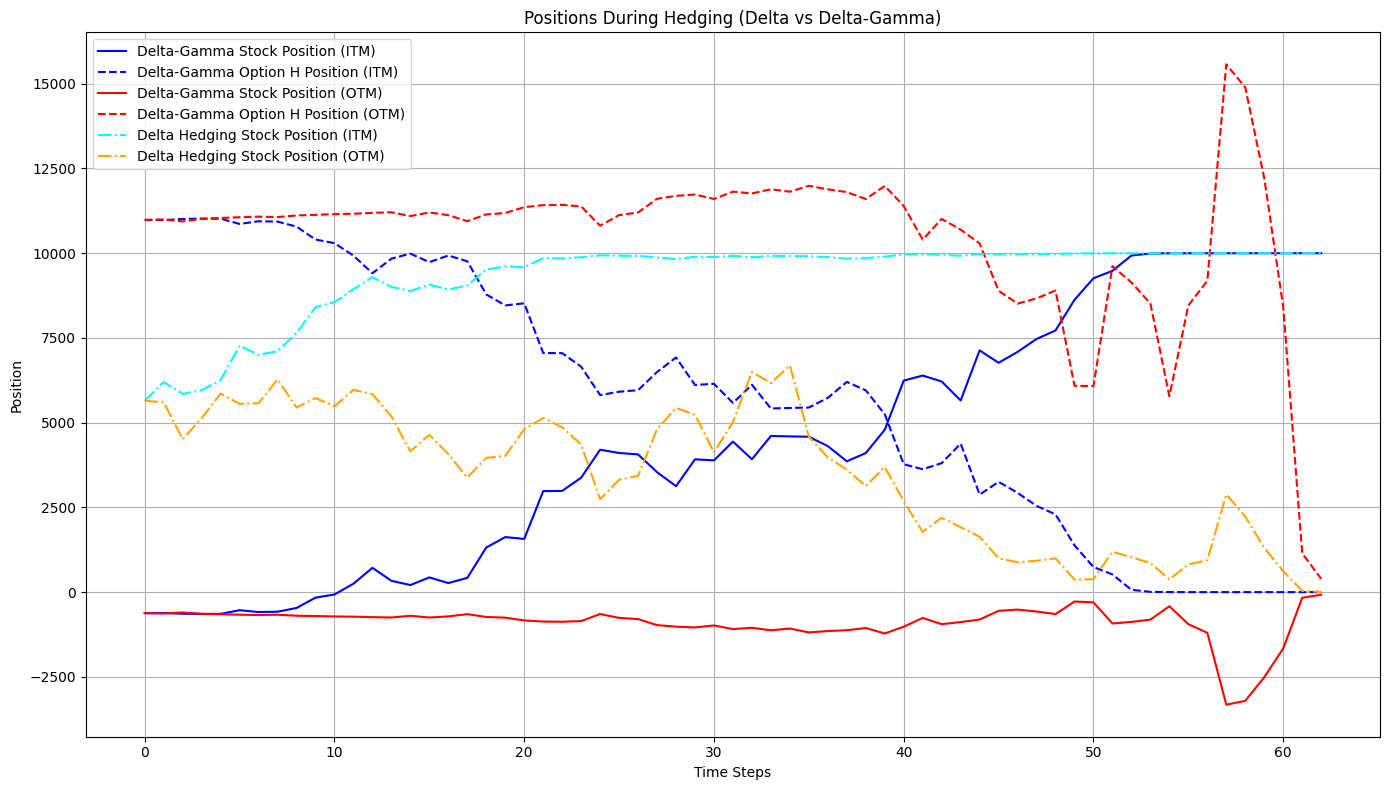

In [ ]:
# Initialize lists to store actual positions during Delta-Gamma hedging
actual_stock_positions_itm = []
actual_option_h_positions_itm = []

actual_stock_positions_otm = []
actual_option_h_positions_otm = []

# Identify ITM and OTM paths based on the final stock prices
final_prices = S_paths[:, -1]  # Extract the final prices of all paths

# ITM path: The first path where the final price exceeds the strike price K_g
itm_path_idx = np.argmax(final_prices > K_g)

# OTM path: The first path where the final price is below the strike price K_g
otm_path_idx = np.argmax(final_prices < K_g)

# Initialize PortfolioManager instances for ITM and OTM paths
pm_itm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)
pm_itm.trade_option(-10000, option_paths[itm_path_idx, 0], option_commission_fee)
pm_otm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)
pm_otm.trade_option(-10000, option_paths[otm_path_idx, 0], option_commission_fee)

for t in range(num_steps):
    # ITM positions
    stock_price_itm = S_paths[itm_path_idx, t]
    delta_main_itm = delta_paths[itm_path_idx, t]
    gamma_main_itm = gamma_paths[itm_path_idx, t]
    delta_sub_itm = gamma_option_delta_paths[itm_path_idx, t]
    gamma_sub_itm = gamma_option_gamma_paths[itm_path_idx, t]
    gamma_option_price_itm = gamma_option_paths[itm_path_idx, t]

    # Perform Delta-Gamma hedging for ITM
    pm_itm.delta_gamma_hedging(
        delta_main=delta_main_itm,
        gamma_main=gamma_main_itm,
        delta_sub=delta_sub_itm,
        gamma_sub=gamma_sub_itm,
        gamma_option_price=gamma_option_price_itm,
        stock_price=stock_price_itm,
        stock_commission_fee=stock_commission_fee,
        option_commission_fee=option_commission_fee,
    )

    # Record actual positions for ITM
    actual_stock_positions_itm.append(pm_itm.share_of_stock)
    actual_option_h_positions_itm.append(pm_itm.share_of_gamma_option)

    # OTM positions
    stock_price_otm = S_paths[otm_path_idx, t]
    delta_main_otm = delta_paths[otm_path_idx, t]
    gamma_main_otm = gamma_paths[otm_path_idx, t]
    delta_sub_otm = gamma_option_delta_paths[otm_path_idx, t]
    gamma_sub_otm = gamma_option_gamma_paths[otm_path_idx, t]
    gamma_option_price_otm = gamma_option_paths[otm_path_idx, t]

    # Perform Delta-Gamma hedging for OTM
    pm_otm.delta_gamma_hedging(
        delta_main=delta_main_otm,
        gamma_main=gamma_main_otm,
        delta_sub=delta_sub_otm,
        gamma_sub=gamma_sub_otm,
        gamma_option_price=gamma_option_price_otm,
        stock_price=stock_price_otm,
        stock_commission_fee=stock_commission_fee,
        option_commission_fee=option_commission_fee,
    )

    # Record actual positions for OTM
    actual_stock_positions_otm.append(pm_otm.share_of_stock)
    actual_option_h_positions_otm.append(pm_otm.share_of_gamma_option)

# Plot the results
plt.figure(figsize=(14, 8))

# ITM positions
plt.plot(actual_stock_positions_itm, label="Actual Stock Position (ITM)", linestyle="-", color="blue")
plt.plot(actual_option_h_positions_itm, label="Actual Option H Position (ITM)", linestyle="--", color="blue")

# OTM positions
plt.plot(actual_stock_positions_otm, label="Actual Stock Position (OTM)", linestyle="-", color="red")
plt.plot(actual_option_h_positions_otm, label="Actual Option H Position (OTM)", linestyle="--", color="red")

# Add labels and legend
plt.title("Actual Positions During Delta-Gamma Hedging (ITM vs OTM)")
plt.xlabel("Time Steps")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# Initialize lists to store actual positions during Delta Hedging
delta_stock_positions_itm = []
delta_stock_positions_otm = []

# Initialize PortfolioManager instances for Delta Hedging ITM and OTM paths
pm_delta_itm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)
pm_delta_itm.trade_option(-10000, option_paths[itm_path_idx, 0], option_commission_fee)

pm_delta_otm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)
pm_delta_otm.trade_option(-10000, option_paths[otm_path_idx, 0], option_commission_fee)

for t in range(num_steps):
    # ITM Delta Hedging
    stock_price_itm = S_paths[itm_path_idx, t]
    delta_itm = delta_paths[itm_path_idx, t]

    # Perform Delta Hedging for ITM
    pm_delta_itm.delta_hedging(delta_itm, stock_price_itm, stock_commission_fee)

    # Record Delta Hedging positions for ITM
    delta_stock_positions_itm.append(pm_delta_itm.share_of_stock)

    # OTM Delta Hedging
    stock_price_otm = S_paths[otm_path_idx, t]
    delta_otm = delta_paths[otm_path_idx, t]

    # Perform Delta Hedging for OTM
    pm_delta_otm.delta_hedging(delta_otm, stock_price_otm, stock_commission_fee)

    # Record Delta Hedging positions for OTM
    delta_stock_positions_otm.append(pm_delta_otm.share_of_stock)

# Plot the results
plt.figure(figsize=(14, 8))

# ITM Delta-Gamma positions
plt.plot(actual_stock_positions_itm, label="Delta-Gamma Stock Position (ITM)", linestyle="-", color="blue")
plt.plot(actual_option_h_positions_itm, label="Delta-Gamma Option H Position (ITM)", linestyle="--", color="blue")

# OTM Delta-Gamma positions
plt.plot(actual_stock_positions_otm, label="Delta-Gamma Stock Position (OTM)", linestyle="-", color="red")
plt.plot(actual_option_h_positions_otm, label="Delta-Gamma Option H Position (OTM)", linestyle="--", color="red")

# ITM Delta positions
plt.plot(delta_stock_positions_itm, label="Delta Hedging Stock Position (ITM)", linestyle="-.", color="cyan")

# OTM Delta positions
plt.plot(delta_stock_positions_otm, label="Delta Hedging Stock Position (OTM)", linestyle="-.", color="orange")

# Add labels and legend
plt.title("Positions During Hedging (Delta vs Delta-Gamma)")
plt.xlabel("Time Steps")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()



Simulating for real-world volatility = 0.20
Simulating for real-world volatility = 0.22
Simulating for real-world volatility = 0.24
Simulating for real-world volatility = 0.26
Simulating for real-world volatility = 0.28
Simulating for real-world volatility = 0.30


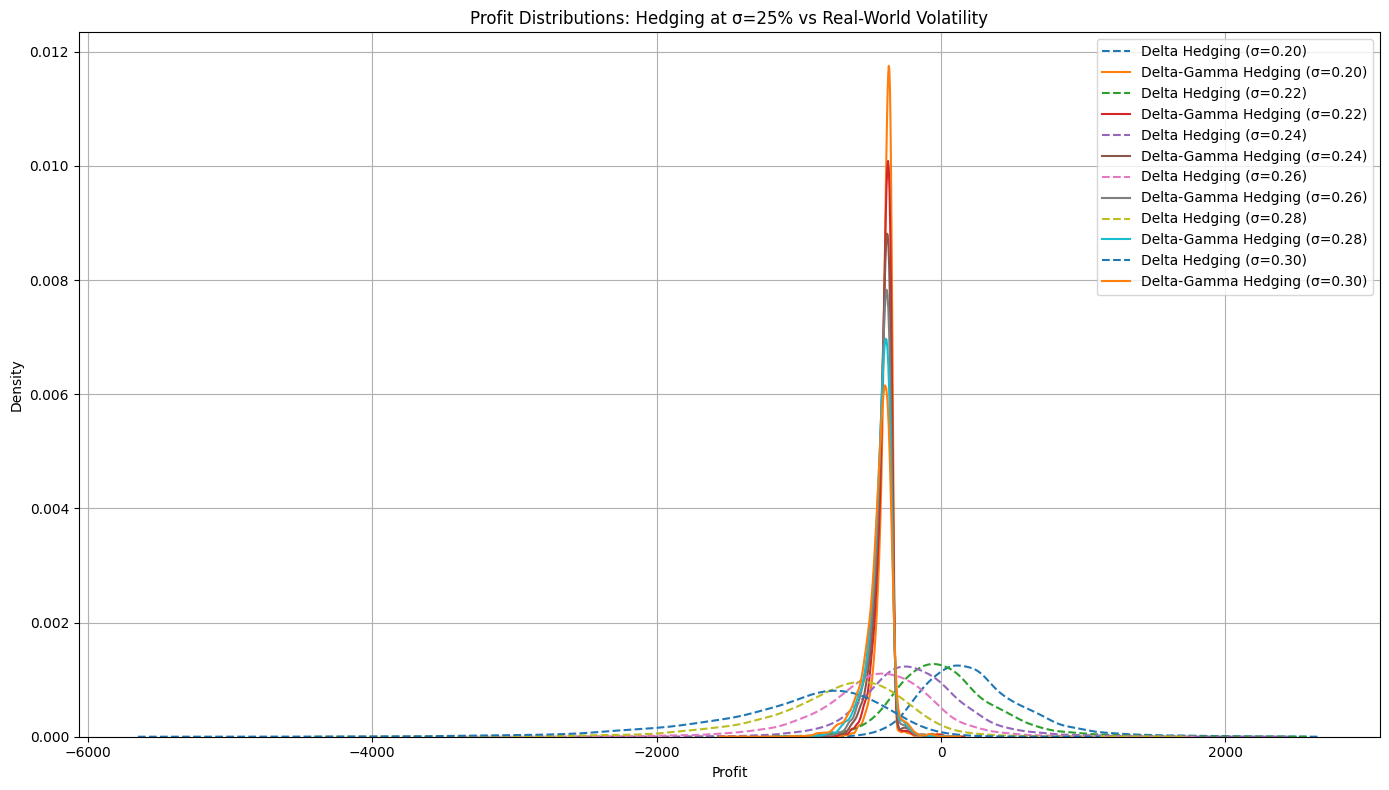

In [ ]:
# Constants for hedging assumption
sigma_hedge = 0.25  # Hedging volatility assumption

real_world_sigmas = np.arange(0.20, 0.31, 0.02)  # Real-world volatilities
profits_dh = []  # Store profits for Delta Hedging
profits_dgh = []  # Store profits for Delta-Gamma Hedging

for sigma_real in real_world_sigmas:
    print(f"Simulating for real-world volatility = {sigma_real:.2f}")

    # Simulate stock paths using real-world volatilityD
    S_paths_real = simulate_stock_paths(s_0, mu, sigma_real, dt, num_days, num_paths, random_seed=42)

    # Hedging metrics are calculated using sigma_hedge
    tau_values = T_g - dt * np.arange(num_steps)
    tau_values_gamma = T_h - dt * np.arange(num_steps)

    delta_paths_hedge = np.zeros((num_paths, num_steps))
    gamma_paths_hedge = np.zeros((num_paths, num_steps))
    option_paths_hedge = np.zeros((num_paths, num_steps))
    gamma_option_delta_paths_hedge = np.zeros((num_paths, num_steps))
    gamma_option_gamma_paths_hedge = np.zeros((num_paths, num_steps))
    gamma_option_paths_hedge = np.zeros((num_paths, num_steps))

    for t in range(num_steps):
        delta_paths_hedge[:, t] = get_delta(S_paths_real[:, t], K_g, r, tau_values[t], sigma_hedge)
        gamma_paths_hedge[:, t] = get_gamma(S_paths_real[:, t], K_g, r, tau_values[t], sigma_hedge)
        option_paths_hedge[:, t] = get_call_option_price(S_paths_real[:, t], K_g, r, tau_values[t], sigma_hedge)

        gamma_option_delta_paths_hedge[:, t] = get_delta(S_paths_real[:, t], K_h, r, tau_values_gamma[t], sigma_hedge)
        gamma_option_gamma_paths_hedge[:, t] = get_gamma(S_paths_real[:, t], K_h, r, tau_values_gamma[t], sigma_hedge)
        gamma_option_paths_hedge[:, t] = get_call_option_price(S_paths_real[:, t], K_h, r, tau_values_gamma[t], sigma_hedge)

    # Delta Hedging
    dh_profits = []
    for path in range(num_paths):
        stock_path = S_paths_real[path, :num_steps]
        delta_path = delta_paths_hedge[path]
        pm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)
        pm.trade_option(-10000, option_paths_hedge[path, 0], option_commission_fee)

        for t in range(num_steps):
            pm.delta_hedging(delta_path[t], stock_path[t], stock_commission_fee)
            pm.update_cash_with_interest(r, dt)

        final_profit = pm.get_profit(stock_path[-1], K_g)
        dh_profits.append(final_profit)

    profits_dh.append(dh_profits)

    # Delta-Gamma Hedging
    dgh_profits = []
    for path in range(num_paths):
        stock_path = S_paths_real[path, :num_steps]
        pm = PortfolioManager(share_of_stock=0, share_of_option=0, cash=0)
        pm.trade_option(-10000, option_paths_hedge[path, 0], option_commission_fee)

        for t in range(num_steps):
            pm.delta_gamma_hedging(
                delta_main=delta_paths_hedge[path, t],
                gamma_main=gamma_paths_hedge[path, t],
                delta_sub=gamma_option_delta_paths_hedge[path, t],
                gamma_sub=gamma_option_gamma_paths_hedge[path, t],
                gamma_option_price=gamma_option_paths_hedge[path, t],
                stock_price=stock_path[t],
                stock_commission_fee=stock_commission_fee,
                option_commission_fee=option_commission_fee,
            )
            pm.update_cash_with_interest(r, dt)

        final_profit = pm.get_profit(stock_path[-1], K_g, gamma_option_price=gamma_option_paths_hedge[path, -1])
        dgh_profits.append(final_profit)

    profits_dgh.append(dgh_profits)

# Plot profit distributions for Delta and Delta-Gamma hedging
plt.figure(figsize=(14, 8))
for i, sigma_real in enumerate(real_world_sigmas):
    sns.kdeplot(profits_dh[i], label=f"Delta Hedging (\u03C3={sigma_real:.2f})", linestyle="--")
    sns.kdeplot(profits_dgh[i], label=f"Delta-Gamma Hedging (\u03C3={sigma_real:.2f})", linestyle="-")

plt.title("Profit Distributions: Hedging at σ=25% vs Real-World Volatility")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
